# Import Packages

In [1]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread, imshow
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import xml.etree.ElementTree as ET

# Loading Images and Annotations

In [2]:
img_dir = "C:/Github/Img_Classifier/images/Images"
ant_dir = "C:/Github/Img_Classifier/annotations/Annotation"
X=[] #input array
Y=[] #output array

bnd_dict = {}

# Load annotations
label_count = 0
for sub_dir in os.listdir(ant_dir):
    label_count += 1
    label = sub_dir.split("-")[1]
    print(label)
    path=os.path.join(ant_dir,sub_dir)
    for ant in os.listdir(path):
        if ant[0] != 'n': continue
        tree = ET.parse(os.path.join(path,ant))
        root = tree.getroot()
        bndbox = root.find("object").find("bndbox")
        xmin = int(bndbox.findtext("xmin"))
        ymin = int(bndbox.findtext("ymin"))
        xmax = int(bndbox.findtext("xmax"))
        ymax = int(bndbox.findtext("ymax"))
        bnd_dict[ant] = [xmin, ymin, xmax, ymax]
    if label_count >= 20: break

Chihuahua
Japanese_spaniel
Maltese_dog
Pekinese
Shih
Blenheim_spaniel
papillon
toy_terrier
Rhodesian_ridgeback
Afghan_hound
basset
beagle
bloodhound
bluetick
black
Walker_hound
English_foxhound
redbone
borzoi
Irish_wolfhound


In [3]:
# Load images      
label_count = 0
for sub_dir in os.listdir(img_dir):
    label_count += 1
    label = sub_dir.split("-")[1]
    #print(label)
    path=os.path.join(img_dir,sub_dir)
    for img in os.listdir(path):
        if img[0] != 'n': continue
        img_array=imread(os.path.join(path,img))
        #imshow(img_array)
        #plt.show()
        bnd = bnd_dict[img.split(".")[0]]         
        img_bnd = img_array[bnd[1]:bnd[3],bnd[0]:bnd[2]]  # Use bndbox to crop image
        #imshow(img_bnd)
        #plt.show()
        #print(img_bnd)
        img_resized=resize(img_bnd,(150, 150, 3))#(150,150,3))
        #print(img_resized)
        X.append(img_resized)#.flatten()) # don't flatten it if CNN
        Y.append(label_count-1)
        
        img_fliplr = np.fliplr(img_resized)
        X.append(img_fliplr)#.flatten())
        Y.append(label_count-1)
        
        img_flipud = np.flipud(img_resized)
        X.append(img_flipud)#.flatten())
        Y.append(label_count-1)
        
    print(f'loaded category:{label} successfully')
    if label_count >= 20: break

X=np.array(X)#.astype('float16')
Y=np.array(Y)#.astype('float16')
print(X.shape)
print(Y.shape)

loaded category:Chihuahua successfully
loaded category:Japanese_spaniel successfully
loaded category:Maltese_dog successfully
loaded category:Pekinese successfully
loaded category:Shih successfully
loaded category:Blenheim_spaniel successfully
loaded category:papillon successfully
loaded category:toy_terrier successfully
loaded category:Rhodesian_ridgeback successfully
loaded category:Afghan_hound successfully
loaded category:basset successfully
loaded category:beagle successfully
loaded category:bloodhound successfully
loaded category:bluetick successfully
loaded category:black successfully
loaded category:Walker_hound successfully
loaded category:English_foxhound successfully
loaded category:redbone successfully
loaded category:borzoi successfully
loaded category:Irish_wolfhound successfully
(10899, 150, 150, 3)
(10899,)


In [4]:
# print(X)

In [5]:
# Adjusting number of classes according to processing resources

num_classes = 20

# Importing packages for Neural Networks

In [6]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, TensorDataset
%matplotlib inline
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim

In [7]:
# Setting up garbage collector to clear cache and allow memory space.
import gc

gc.collect()

4

In [8]:
import torch
torch.cuda.empty_cache()

torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

# Build datasets and dataloaders

In [9]:
tensor_x = torch.Tensor(X) # transform to torch tensor
tensor_x = torch.swapaxes(tensor_x, 2, 3)
tensor_x = torch.swapaxes(tensor_x, 1, 2)
print(tensor_x.size())
tensor_y = torch.Tensor(Y).type(torch.LongTensor)
print(tensor_y.size())

dataset = TensorDataset(tensor_x,tensor_y)
train_size = int(X.shape[0]*0.8)
val_size = int(X.shape[0]*0.1)
test_size = X.shape[0] - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

#passing the train, val and test datasets to the dataloader
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=False)

torch.Size([10899, 3, 150, 150])
torch.Size([10899])


# A 2-layer CNN implementation

In [10]:
# Created a CNN class:
class CNN(nn.Module):
    
    # Defining the neural net architecture
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        
        # Convolution layer with 3 input channels, 32 kernels of size 3 x 3
        self.convolutional_layer_1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 2)
        
        # Max-pooling of size 2 x 2
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        # Convolution layer with 32 input channels, 32 kernels of size  3 x 3
        self.convolutional_layer_2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3)
        
        # Max-pooling of size 2 x 2
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        # Flatten:
        self.flatten = nn.Flatten()
        
        # Linear layer with 128 neurons
        self.feedforward_1 = nn.Linear(17*17*32,128)
        
        # Linear layer with number of classes output neurons
        self.feedforward_3 = nn.Linear(128,num_classes)
        
    # Forward pass:
    def forward(self, x):
        
        out = self.convolutional_layer_1(x)
        
        out = self.max_pool1(F.relu(out))
        
        out = self.convolutional_layer_2(out)
        
        out = self.max_pool2(F.relu(out))
        
        out = self.flatten(out)
        
        out = self.feedforward_1(out)
        
        out = self.feedforward_3(F.relu(out))
        
        # Adding a softmax activation function for multi-class labelling problem:
        out = F.softmax(out)
        
        return out        

In [11]:
# Train the model
device = 'cuda' # if you dont have a gpu, set device = cpu here

model = CNN(num_classes)

model = model.to(device=device) #to send the model for training on either cuda or cpu

# Training and validation

In [12]:
## Loss and optimizer
learning_rate = 1e-5
load_model = True

# Choosing the class with max probability. 
criterion = nn.CrossEntropyLoss()

# Adding weight decay of 1e-5 for l2 norm (ridge) cost optimization. This is specific to pytorch application.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Tracking losses:
val_acc = []
tr_loss = []

for epoch in range(50): # How many epochs?
    loss_ep = 0
    
    print("learning rate: ", learning_rate)
    
    for batch_idx, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        scores = model(data)
        loss = criterion(scores,targets)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch} :::: {loss_ep/len(train_dl)}")
    tr_loss.append(loss_ep/len(train_dl))

    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            scores = model(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )
        val_acc.append(float(num_correct) / float(num_samples) * 100)

learning rate:  1e-05


C:\Users\ashwi\AppData\Local\Temp/ipykernel_11196/266847560.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)


Loss in epoch 0 :::: 2.989631445036022
Got 82 / 1089 with accuracy 7.53
learning rate:  1e-05
Loss in epoch 1 :::: 2.971808616393203
Got 116 / 1089 with accuracy 10.65
learning rate:  1e-05
Loss in epoch 2 :::: 2.960866078980472
Got 120 / 1089 with accuracy 11.02
learning rate:  1e-05
Loss in epoch 3 :::: 2.952965810758258
Got 148 / 1089 with accuracy 13.59
learning rate:  1e-05
Loss in epoch 4 :::: 2.946133855067262
Got 157 / 1089 with accuracy 14.42
learning rate:  1e-05
Loss in epoch 5 :::: 2.9399461702469294
Got 155 / 1089 with accuracy 14.23
learning rate:  1e-05
Loss in epoch 6 :::: 2.9340107869664465
Got 161 / 1089 with accuracy 14.78
learning rate:  1e-05
Loss in epoch 7 :::: 2.928623207774731
Got 168 / 1089 with accuracy 15.43
learning rate:  1e-05
Loss in epoch 8 :::: 2.924188854934972
Got 163 / 1089 with accuracy 14.97
learning rate:  1e-05
Loss in epoch 9 :::: 2.9204582638696794
Got 169 / 1089 with accuracy 15.52
learning rate:  1e-05
Loss in epoch 10 :::: 2.916826782314055

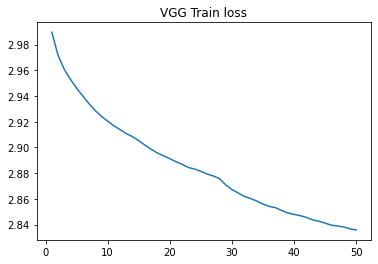

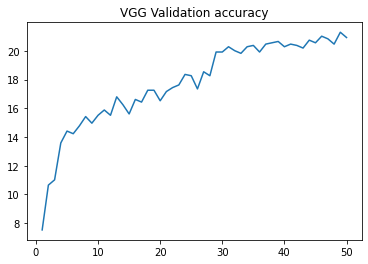

In [13]:
# Plots out train loss and validation accuracy
plt.title("VGG Train loss")
plt.plot(list(range(1, len(tr_loss)+1)), tr_loss)

plt.show()

plt.title("VGG Validation accuracy")
plt.plot(list(range(1, len(val_acc)+1)), val_acc)

plt.show()

# Testing

In [14]:
y_pred = []
y_test = []
# Prints out test accuracy
with torch.no_grad():
    num_correct = 0
    num_samples = 0
    for batch_idx, (data,targets) in enumerate(test_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        scores = model(data)
        _, predictions = scores.max(1)
        y_test.append(targets.tolist())
        y_pred.append(predictions.tolist())
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
    print(
        f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
    )

C:\Users\ashwi\AppData\Local\Temp/ipykernel_11196/266847560.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)


Got 243 / 1091 with accuracy 22.27


In [15]:
y_pred = [item for sublist in y_pred for item in sublist]

In [16]:
y_test = [item for sublist in y_test for item in sublist]

# Performance metrics

In [17]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        46
           1       0.21      0.61      0.31        46
           2       0.35      0.67      0.46        76
           3       0.00      0.00      0.00        40
           4       0.15      0.19      0.17        77
           5       0.21      0.33      0.26        61
           6       0.00      0.00      0.00        64
           7       0.00      0.00      0.00        53
           8       0.00      0.00      0.00        48
           9       0.25      0.51      0.34        68
          10       0.00      0.00      0.00        52
          11       0.15      0.18      0.16        57
          12       0.19      0.65      0.30        54
          13       0.00      0.00      0.00        49
          14       0.26      0.61      0.36        49
          15       0.00      0.00      0.00        47
          16       0.00      0.00      0.00        44
          17       0.00    

C:\Users\ashwi\project\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ashwi\project\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ashwi\project\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
